In [1]:
import numpy as np
import operator
import logging
import time
from functools import partial

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass, matched_filter, sigma
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform

import optuna

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NeedsInvestigatingCallback(object):
    """A callback for Optuna which identifies potential events."""

    def __init__(self, early_stopping_rounds: int, snr_threshold: int, direction: str = "minimize") -> None:
        self.snr_threshold = snr_threshold
        self.early_stopping_rounds = early_stopping_rounds
        
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Goes onto Stocastic Gradient Descent."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._score >= self.snr_threshold:
            if self._iter >= self.early_stopping_rounds:
                study.stop()
                print(study.best_params)

In [3]:
def confirmed_gw_timeseries(event, detector):
    merger = Merger(event)

    # Get the data from the Hanford detector
    strain = merger.strain(detector)

    # Remove the low frequency content and downsample the data to 2048Hz
    strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

    # Remove 2 seconds of data from both the beginning and end
    conditioned = strain.crop(2, 2)
    
    return conditioned

def confirmed_gw_psd(conditioned):
    psd = conditioned.psd(4)

    psd = interpolate(psd, conditioned.delta_f)

    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=15)
    return psd

def optuna_waveform_template(delta_freqs, m1, m2):
    return get_fd_waveform(approximant="IMRPhenomD", mass1=m1, mass2=m2, delta_f=delta_freqs, f_lower=20)

def snr(psd, f_conditioned, template): 
    snr = matched_filter(template, f_conditioned, psd=psd, low_frequency_cutoff=20)
    snr = snr.crop(2 + 4, 2)
    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    return float(snrp)

In [4]:
def objective(trial):
    m1 = trial.suggest_float('m1', 2, 100, step=0.000001)
    m2 = trial.suggest_float('m2', 2, 100, step=0.000001)
    template, _ = my_optuna_waveform_template(m1, m2)
    template.resize(len(psd))
    return my_snr(template)

In [5]:
#Events = ["GW150914", "GW151012", "GW151226", "GW170104", "GW170608", "GW170729", "GW170809", "GW170814", "GW170817", "GW170818", "GW170823"]

Events = ["GW150914"]

In [6]:
for event in Events:
    conditioned = confirmed_gw_timeseries(event, detector='H1')
    psd = confirmed_gw_psd(conditioned)
    f_conditioned = conditioned.to_frequencyseries()
    delta_freqs = conditioned.delta_f

    #Get the stage ready for the template
    my_optuna_waveform_template = partial(optuna_waveform_template, delta_freqs)
    my_snr = partial(snr, psd, f_conditioned)
    
    #Define the Optuna runs    
    optuna.logging.disable_default_handler()
    direction="maximize"
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction=direction)
    needs_to_be_investigated = NeedsInvestigatingCallback(50, snr_threshold=200, direction=direction)
    start_time = time.time()
    study.optimize(objective, callbacks=[needs_to_be_investigated], n_trials=100)
    print(("Time taken", time.time() - start_time))
    print(f'The event is {event} and has the best {study.best_params} with a snr {study.best_value}')

('Time taken', 4.125453472137451)
The event is GW150914 and has the best {'m1': 30.58168, 'm2': 42.734753} with a snr 19.616559883283212


/tmp/ipykernel_15260/2224681768.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, target_name="SNR")
Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Text(0, 0.5, 'Mass 2')

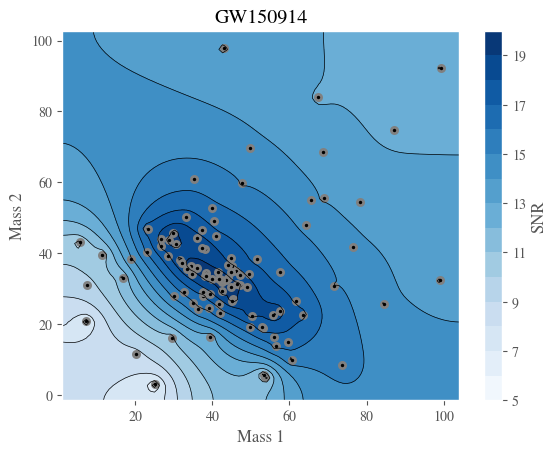

In [7]:
fig = optuna.visualization.matplotlib.plot_contour(study, target_name="SNR")
fig.set_title(f"{event}")
fig.set_xlabel('Mass 1')
fig.set_ylabel('Mass 2')

/tmp/ipykernel_15260/1964054597.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study, target_name="SNR")


Text(0.5, 1.0, '')

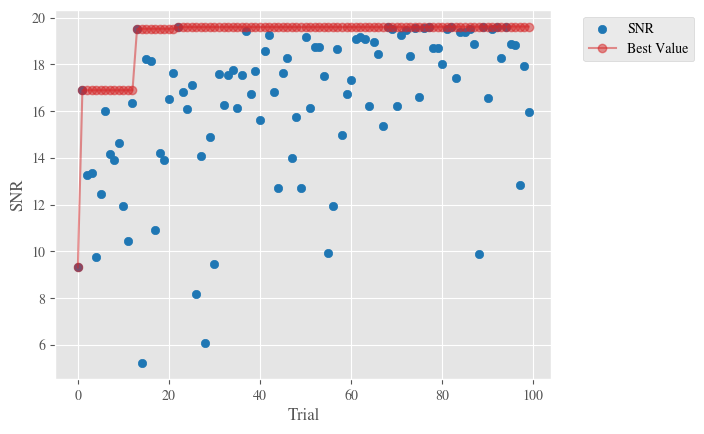

In [8]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study, target_name="SNR")
fig.set_title("")

/tmp/ipykernel_15260/4230620112.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_edf(study)


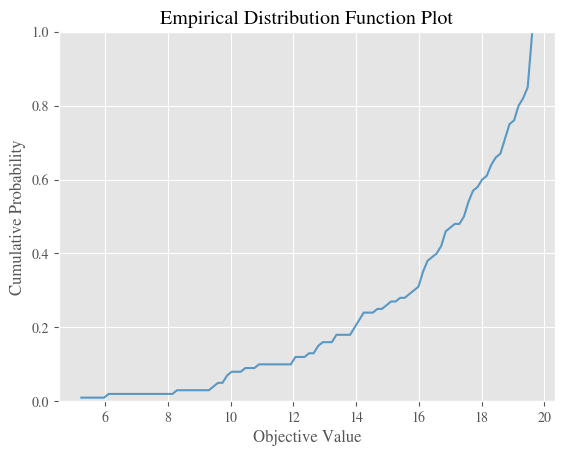

In [9]:
fig = optuna.visualization.matplotlib.plot_edf(study)